# Setup

In [1]:
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
# For colab
if IN_COLAB:
  import sys
  !git clone https://github.com/elements72/EDiReF-subtask-III.git
  %pip install lightning
  %pip install wandb
  sys.path.append('./EDiReF-subtask-III')
  %cd ./EDiReF-subtask-III
  num_workers = 2
else:
  num_workers = 0
  pass

In [2]:
import logging
log = logging.getLogger("pytorch_lightning")
log.propagate = False
log.setLevel(logging.ERROR)

In [3]:
# Reload modules, do not use cache
%load_ext autoreload
%autoreload 2

In [32]:
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import numpy as np
from utils import train_model, hyperparameters_tuning, train_model_seeds
import torch
from baselines import random_metrics, majority_metrics, aggregate_results
from baselines import BertBaseline
from baselines import RandomUniformClassifier
from baselines import MajorityClassifier
from metrics import F1ScoreCumulative, F1ScoreDialogues
import torch
from sklearn.model_selection import train_test_split
from attention import DialoguesAttention
from lstm_model import LSTMResModel
from dataset import MeldDataModule


In [5]:
import wandb
wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: itsalsblashere (alessandrablasioli). Use `wandb login --relogin` to force relogin


True

# Dataset

In [6]:
batch_size = 2
# Create and setup data module
datamodule = MeldDataModule(batch_size=batch_size, num_workers=num_workers)
datamodule.prepare_data()
datamodule.setup()
# Get dataframes
train_data = datamodule.train_data
val_data = datamodule.val_data
test_data = datamodule.test_data
# Get encoder
emotion_encoder = datamodule.emotion_encoder
#Base Dataloaders
train_loader = datamodule.train_dataloader(collate_context=False, batch_size=batch_size)
val_loader = datamodule.val_dataloader(collate_context=False, batch_size=batch_size)
test_loader = datamodule.test_dataloader(collate_context=False, batch_size=batch_size)

In [7]:
from sklearn.utils.class_weight import compute_class_weight

class_weights_emotion = compute_class_weight('balanced', classes=np.unique(train_data['emotions'].explode()),
                                             y=train_data['emotions'].explode())
class_weights_emotion = torch.tensor(class_weights_emotion, dtype=torch.float)

class_weights_trigger = compute_class_weight('balanced', classes=np.unique(train_data['triggers'].explode()), 
                                             y=train_data['triggers'].explode())
class_weights_trigger = torch.tensor(class_weights_trigger, dtype=torch.float)

class_weights_emotion

tensor([1.3135, 4.8692, 4.3329, 0.7756, 0.3249, 2.0598, 1.0525])

In [8]:
def get_hyperparams(model_name, freeze, lr):
    hyperparameters = {
        "lr": lr,
        "class_weights_emotion": class_weights_emotion,
        "class_weights_trigger": class_weights_trigger,
        "hidden_layers": 2,
        "use_encoder_cache": True if freeze else False,
        "encoder_cache_size": 100000,
        "freeze_bert": freeze,
        "dropout": 0.2,
        "bert_model_name": "bert-base-uncased",
        }
    if "lstm" in model_name:
        lstm_kwargs = {
            "hidden_size": 128,
            "num_layers": 2,
            "bidirectional": False,
        }
        hyperparameters["lstm_kwargs"] = lstm_kwargs
    if "emoberta" in model_name:
        hyperparameters["bert_model_name"] = "roberta-large"
    return hyperparameters


In [23]:
lr = 1e-3
epochs = 20
tune_hyperparameters = False
seeds = [6, 9, 42, 150, 300]

batch_size_freeze = 32
batch_size_unfreeze = 8

train_loader_freeze = datamodule.train_dataloader(collate_context=False, batch_size=batch_size_freeze )
val_loader_freeze = datamodule.val_dataloader(collate_context=False, batch_size=batch_size_freeze   )
test_loader_freeze = datamodule.test_dataloader(collate_context=False, batch_size=batch_size_freeze  )

train_loader_unfreeze = datamodule.train_dataloader(collate_context=False, batch_size=batch_size_unfreeze)
val_loader_unfreeze = datamodule.val_dataloader(collate_context=False, batch_size=batch_size_unfreeze)
test_loader_unfreeze = datamodule.test_dataloader(collate_context=False, batch_size=batch_size_unfreeze)

train_loader_emoberta = datamodule.train_dataloader(collate_context=True, batch_size=batch_size_unfreeze)
val_loader_emoberta = datamodule.val_dataloader(collate_context=True, batch_size=batch_size_unfreeze)
test_loader_emoberta = datamodule.test_dataloader(collate_context=True, batch_size=batch_size_unfreeze)


models = {
    "bert-baseline-freeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-baseline-unfreeze":{'model_class': BertBaseline, 'hyperparameters': get_hyperparams("bert-baseline-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-lstm-freeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-lstm-unfreeze":{'model_class': LSTMResModel, 'hyperparameters': get_hyperparams("bert-lstm-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "bert-attention-freeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-freeze", freeze=True, lr=lr), "train_loader": train_loader_freeze, "val_loader": val_loader_freeze},
    "bert-attention-unfreeze":{'model_class': DialoguesAttention, 'hyperparameters': get_hyperparams("bert-attention-unfreeze", freeze=False, lr=lr), "train_loader": train_loader_unfreeze, "val_loader": val_loader_unfreeze},
    "emoberta-current": {'model_class': BertBaseline, 'hyperparameters': get_hyperparams("emoberta", freeze=True, lr=lr), "train_loader": train_loader_emoberta, "val_loader": val_loader_emoberta},
    }

# to_train = ['emoberta']
    
# for model_name, model_dict in models.items():
#   if model_name not in to_train:
#     continue
#   train_model_seeds(**model_dict, model_name=model_name, seeds=seeds, epochs=epochs, wandb=wandb)

In [16]:
from utils import load_model, evaluate_model
import os
results_path = Path("results")
results = pd.DataFrame()
# Check if file exists
if os.path.isfile(results_path / "test_results.csv"):
    results = pd.read_csv(results_path / "test_results.csv", index_col=0)
else:
    for model_name, model_dict in models.items():
        for seed in seeds:
            print(f"Evaluating {model_name} with seed {seed}    ")
            model = load_model(model_dict["model_class"], f"{model_name}-seed-{seed}")
            if model is None:
                continue
            result = evaluate_model(model, f"{model_name}-seed-{seed}", test_loader_unfreeze, test=True, verbose=False)
            # concat results
            results = pd.concat([results, result])
    # save results
    results.to_csv(results_path / "test_results.csv", index=True)

In [9]:
test_results = results.drop(columns=["test_loss", "test_emotion_loss", "test_trigger_loss"])

NameError: name 'results' is not defined

In [36]:
# Compute mean and std for each column
test_results_aggregated = test_results.copy()
test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")
test_results_aggregated = test_results_aggregated.groupby(level=0).agg(["mean", "std"])
test_results_aggregated

/tmp/ipykernel_9907/2701999117.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_results_aggregated.index =  test_results_aggregated.index.str.replace("-seed-\d+", "")


f1_test_cumulative_emotion            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.330336  0.021319   
bert-attention-unfreeze                   0.401854  0.024033   
bert-baseline-freeze                      0.360447  0.021234   
bert-baseline-unfreeze                    0.408425  0.013422   
bert-lstm-freeze                          0.365662  0.014246   
bert-lstm-unfreeze                        0.413969  0.009863   
emoberta-current                          0.566634  0.014617   

                        f1_test_cumulative_trigger            \
                                              mean       std   
model_name                                                     
bert-attention-freeze                     0.301887  0.020448   
bert-attention-unfreeze                   0.330395  0.009883   
bert-baseline-freeze                      0.279776  0.001793   
bert-baseline-unfreeze                    0.287504  0.007836   
bert-lstm-freeze                          0.339595  0.005212   
bert-lstm-unfreeze                        0.292828  0.008305   
emoberta-current                          0.275746  0.012876   

                        f1_test_cumulative_trigger_multi            \
                                                    mean       std   
model_name                                                           
bert-attention-freeze                           0.441885  0.066156   
bert-attention-unfreeze                         0.557142  0.017246   
bert-baseline-freeze                            0.395314  0.040571   
bert-baseline-unfreeze                          0.472265  0.015174   
bert-lstm-freeze                                0.569556  0.019693   
bert-lstm-unfreeze                              0.461105  0.019580   
emoberta-current                                0.425285  0.032207   

                        f1_test_dialogues_emotion            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.320883  0.045570   
bert-attention-unfreeze                  0.404260  0.019591   
bert-baseline-freeze                     0.342467  0.035196   
bert-baseline-unfreeze                   0.399961  0.017134   
bert-lstm-freeze                         0.354995  0.024368   
bert-lstm-unfreeze                       0.404116  0.026548   
emoberta-current                         0.538498  0.019573   

                        f1_test_dialogues_trigger            \
                                             mean       std   
model_name                                                    
bert-attention-freeze                    0.297778  0.013616   
bert-attention-unfreeze                  0.302122  0.015583   
bert-baseline-freeze                     0.318977  0.006458   
bert-baseline-unfreeze                   0.312562  0.010616   
bert-lstm-freeze                         0.280746  0.026727   
bert-lstm-unfreeze                       0.325001  0.009811   
emoberta-current                         0.306650  0.024807   

                        f1_test_dialogues_trigger_multi            
                                                   mean       std  
model_name                                                         
bert-attention-freeze                          0.345473  0.042724  
bert-attention-unfreeze                        0.479430  0.014735  
bert-baseline-freeze                           0.401805  0.037593  
bert-baseline-unfreeze                         0.475244  0.015630  
bert-lstm-freeze                               0.437231  0.010420  
bert-lstm-unfreeze                             0.458492  0.022716  
emoberta-current                               0.431021  0.027194

In [35]:
# Random Classifier
# Test set
random_uniform_classifier = RandomUniformClassifier(7, 1)
metrics_random, emotions_predictions, triggers_predictions = random_metrics(random_uniform_classifier, test_loader, num_classes_emotions=8, num_classes_triggers=2)
# Validation set
metrics_random_val, emotions_predictions_val, triggers_predictions_val= random_metrics(random_uniform_classifier, val_loader, num_classes_emotions=8, num_classes_triggers=2)


# Majority Classifier
# Test set
majority_classifier = MajorityClassifier(num_classes_emotions=7, num_classes_triggers=2, padding_value_emotions=7, padding_value_triggers=2)
majority_classifier.fit(train_loader)
metrics_majority, emotions_predictions, triggers_predictions = majority_metrics(majority_classifier, test_loader, num_classes_emotions=8, num_classes_triggers=2)
# Validation set
metrics_majority_val, emotions_predictions_val, triggers_predictions_val = majority_metrics(majority_classifier, val_loader, num_classes_emotions=8, num_classes_triggers=2)
#Results
aggregated_results = aggregate_results(metrics_random, metrics_majority, metrics_random_val, metrics_majority_val)

aggregated_results

,F1 Cumulative_Emotions,F1 Dialogues_Emotions,F1 Cumulative_Triggers_Binary,F1 Dialogues_Triggers_Binary,F1 Cumulative_Triggers_Multiclass,F1 Dialogues_Triggers_Multiclass
Random Classifier (test),0.118280,0.088153,0.0,0.0,0.460621,0.451751
Random Classifier (val),0.119389,0.090542,0.0,0.0,0.440633,0.426301
Majority Classifier (test),0.084635,0.177654,0.0,0.0,0.460621,0.451751
Majority Classifier (val),0.085029,0.183634,0.0,0.0,0.440633,0.426301


# Error analysis

In [91]:
# Pick best model
best_model_name = test_results["f1_test_cumulative_emotion"].idxmax()
best_model_key = best_model_name.split("-seed")[0]
# Load the best model
best_model = load_model(models[best_model_key]["model_class"], best_model_name)

Some weights of RobertaModel were not initialized from the model checkpoint at tae898/emoberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using cache of size 100000 for the embedding


In [103]:
def model_predict(loader, model):
    y_pred = {"emotions": torch.Tensor().to('cpu'), "triggers": torch.Tensor().to('cpu')}
    y_true = {"emotions": torch.empty(0, dtype=torch.long).to('cpu'), "triggers": torch.empty(0, dtype=torch.long).to('cpu')}
    for batch in loader:
        preds = model.predict(batch)
        
        emotions = preds["emotions"].to('cpu')
        triggers = preds["triggers"].to('cpu')

        emotions = emotions.reshape(-1, model.emotion_output_dim)
        triggers = triggers.reshape(-1, model.trigger_output_dim)

        y_pred["emotions"] = torch.cat([y_pred["emotions"], emotions])
        y_pred["triggers"] = torch.cat([y_pred["triggers"], triggers])

        y_true["emotions"] = torch.cat([y_true["emotions"], batch["emotions"].reshape(-1).to('cpu')], dim=0)
        y_true["triggers"] = torch.cat([y_true["triggers"], batch["triggers"].reshape(-1).to('cpu')], dim=0)

    return y_pred, y_true

In [123]:
import matplotlib.pyplot as plt
from torchmetrics import PrecisionRecallCurve


def plot_precision_recall(y_pred, y_true, output_dim, labels):
    ignore_index = output_dim
    precision_curve = PrecisionRecallCurve(task="multiclass", num_classes=output_dim, ignore_index=ignore_index)

    print(y_pred.shape)
    curve = precision_curve(y_pred, y_true)
    precision, recall, _ = curve

    plt.figure(figsize=(15, 10))
    plt.title("Precision-Recall Curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim(0, 1)
    plt.ylim(0, 1)107
    plt.grid()

    emotion_to_auc = {}
    for i in range(output_dim):
        emotion = labels[i]
                
        auc = -1 * torch.trapz(precision[i], recall[i])
        
        emotion_to_auc[emotion] = auc.item()
        
        plt.plot(recall[i], precision[i], label=f"{emotion}: {auc:.2f}")

    plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
    plt.show()


torch.Size([4170, 7])


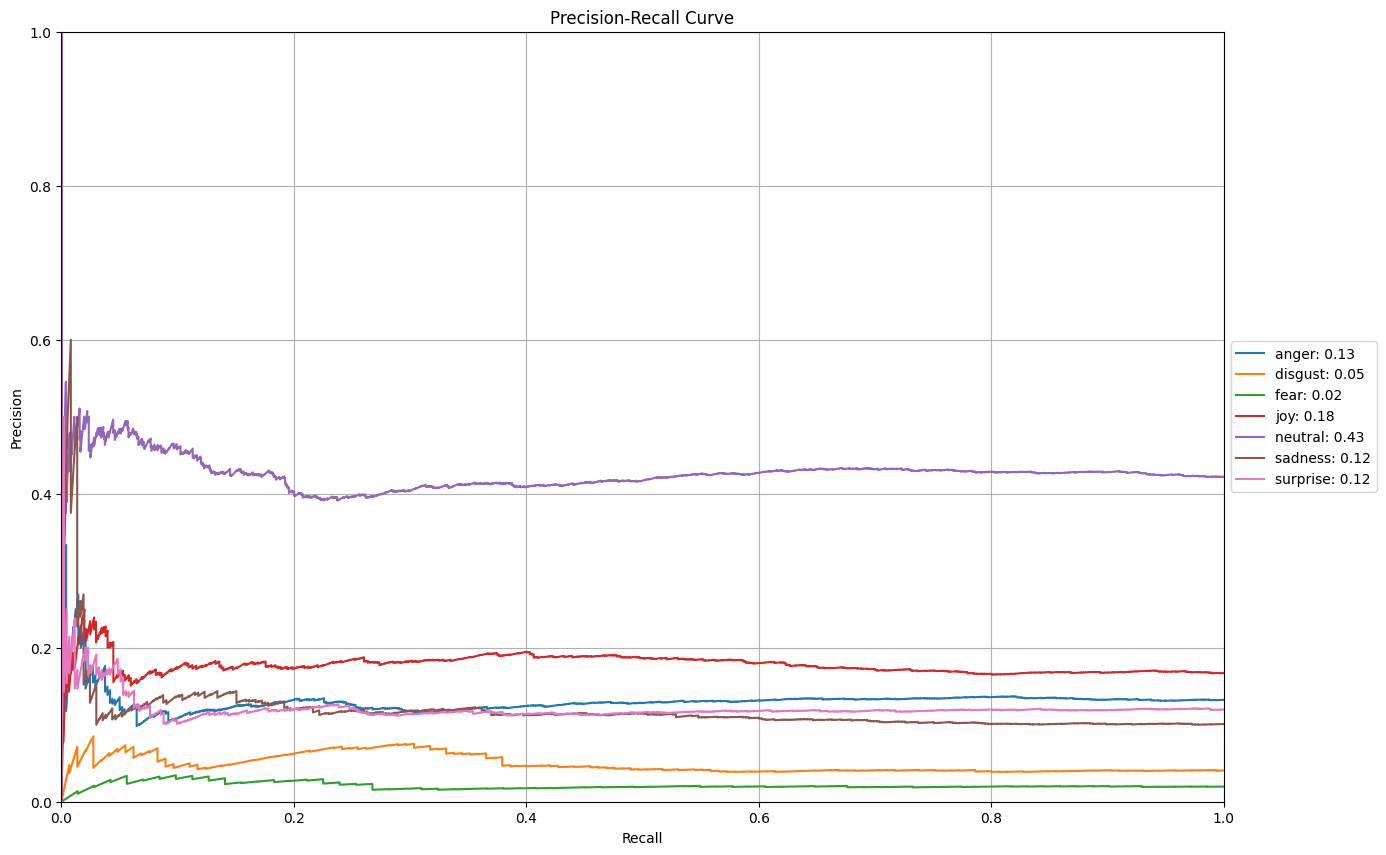

torch.Size([4170, 2])


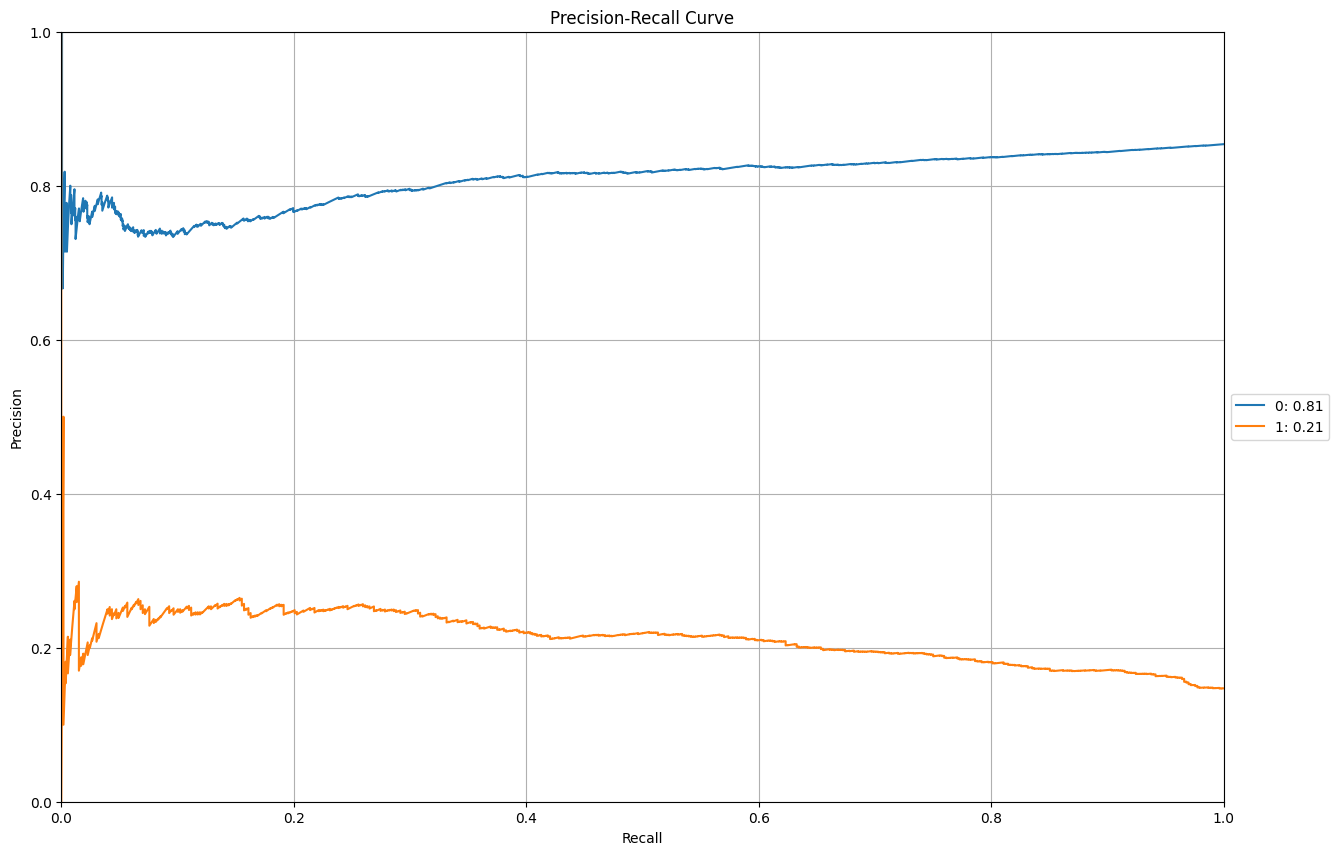

In [130]:
y_pred, y_true = model_predict(test_loader, best_model)
plot_precision_recall(y_pred["emotions"], y_true["emotions"], best_model.emotion_output_dim, emotion_encoder.classes_)
plot_precision_recall(y_pred["triggers"], y_true["triggers"], best_model.trigger_output_dim, ["0", "1"])

In [151]:
from torchmetrics.classification import MulticlassConfusionMatrix
def plot_confusion_matrix(y_pred, y_true, labels, output_dim):
    ignore_index = output_dim

    confusion_matrix_metric = MulticlassConfusionMatrix(num_classes=best_model.emotion_output_dim, ignore_index=ignore_index).to('cpu')

    y_pred_class = torch.argmax(y_pred, dim=1)

    confusion_matrix = confusion_matrix_metric(y_pred_class, y_true)

    # plot confusion matrix
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.imshow(confusion_matrix)
    plt.colorbar()
    plt.xticks(range(ignore_index), labels)
    plt.yticks(range(ignore_index), labels)
    # Insert values in the matrix
    for i in range(ignore_index):
        for j in range(ignore_index):
            plt.text(j, i, confusion_matrix[i, j].item(), ha="center", va="center", color="white" if confusion_matrix[i, j] > 100 else "black")

    # x ticks labels vertical
    plt.xticks(rotation=90)

    plt.show()
    return confusion_matrix

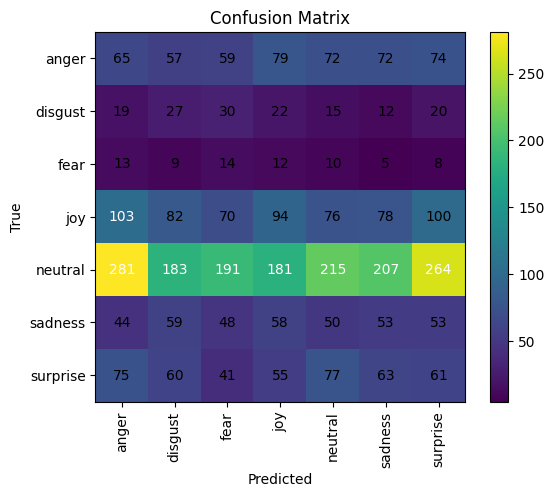

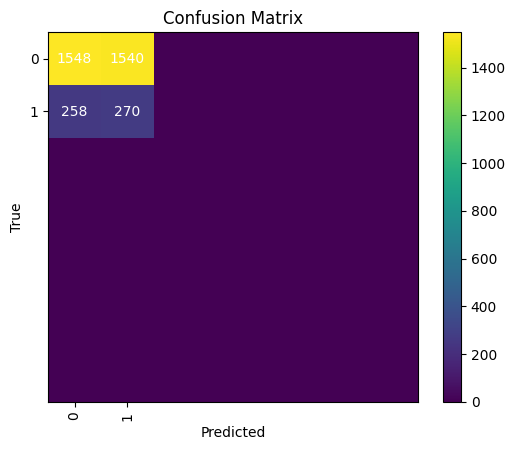

tensor([[1548, 1540,    0,    0,    0,    0,    0],
        [ 258,  270,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0],
        [   0,    0,    0,    0,    0,    0,    0]], device='cpu')

In [152]:
emotion_confusion_matrix = plot_confusion_matrix(y_pred['emotions'], y_true['emotions'], emotion_encoder.classes_, best_model.emotion_output_dim)
plot_confusion_matrix(y_pred['triggers'], y_true['triggers'], ["0", "1"], best_model.trigger_output_dim)

In [155]:
# Find the maximum value outside the diagonal
confused_emotion = {}
    
for i in range(best_model.emotion_output_dim):

    temp_row = emotion_confusion_matrix[i]
    temp_row[i] = -1
    
    # find the emotion that is most confused with the current emotion
    max_emotion = torch.argmax(temp_row)

    # Reverse lookup
    emotion_encoder.classes_[i]
    
    confused_emotion[emotion_encoder.classes_[i]] = {
        "confused_with": emotion_encoder.classes_[max_emotion],
        "n_errors": temp_row[max_emotion].item()
    }
    

top_k_most_confused = best_model.emotion_output_dim
most_confused = sorted(confused_emotion.items(), key=lambda x: x[1]["n_errors"], reverse=True)[:top_k_most_confused]

for i, (emotion, info) in enumerate(most_confused):
    print(f"Top {i + 1} most confused emotion: {emotion}, confused with {info['confused_with']} with {info['n_errors']} errors")


Top 1 most confused emotion: neutral, confused with anger with 281 errors
Top 2 most confused emotion: joy, confused with anger with 103 errors
Top 3 most confused emotion: anger, confused with joy with 79 errors
Top 4 most confused emotion: surprise, confused with neutral with 77 errors
Top 5 most confused emotion: sadness, confused with disgust with 59 errors
Top 6 most confused emotion: disgust, confused with fear with 30 errors
Top 7 most confused emotion: fear, confused with anger with 13 errors


In [222]:
# Get most difficult dialogues
data = []
count = 0
for x in test_loader:
    #print(x)
    pred = best_model.pred(x, None, None)
    emotions_pred = pred["emotions"].tolist()
    emotions_true = x["emotions"].tolist()
    
    utterances = [item for sublist in x["utterances"] for item in sublist]
    emotions_pred = [item for sublist in emotions_pred for item in sublist]
    emotions_true = [item for sublist in emotions_true for item in sublist]
    dialog_id = [i + count for i in range(len(x["utterances"])) for _ in x['utterances'][i]]

    count += len(x['utterances'])
    
    trigger_pred = pred["triggers"].tolist()
    trigger_true = x["triggers"].tolist()
    
    trigger_pred = [item for sublist in trigger_pred for item in sublist]
    trigger_true = [item for sublist in trigger_true for item in sublist]
    
    # Utterances, emotion_pred, emotion_true are lists 
    
    data = data + list(zip(utterances, emotions_pred, emotions_true, trigger_pred, trigger_true, dialog_id))    
    

df = pd.DataFrame(columns=["utterances", "emotion_pred", "emotion_true", "trigger_pred", "trigger_true", "dialog_id"], data=data)
    
df["emotion_correct"] = df["emotion_pred"] == df["emotion_true"]
df["trigger_correct"] = df["trigger_pred"] == df["trigger_true"]

df["emotion_pred"] = df["emotion_pred"].apply(lambda x: emotion_encoder.classes_[x])
df["emotion_true"] = df["emotion_true"].apply(lambda x: emotion_encoder.classes_[x] if x != 7 else "<PAD>")

# Remove rows where emotion true is <PAD>
df = df[df["emotion_true"] != "<PAD>"]

In [223]:
# Create a new index level
df = df.set_index(["dialog_id", df.groupby("dialog_id").cumcount()])
# Make old index incremental

In [233]:
top_k = 3
# Get the most difficult dialogues
most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
# Get most difficult dialogues for trigger
most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]

/tmp/ipykernel_9907/1384951695.py:3: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues = df.groupby("dialog_id").mean().sort_values("emotion_correct", ascending=True).index[:top_k]
/tmp/ipykernel_9907/1384951695.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  most_difficult_dialogues_trigger = df.groupby("dialog_id").mean().sort_values("trigger_correct", ascending=True).index[:top_k]


In [231]:
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues)]

utterances emotion_pred  \
dialog_id                                                                     
0         0                  Jeannine: Night Mon. Night Julio.         fear   
          1                                      Julio: Adiós.         fear   
          2  Monica: Look Julio, someone left their book here.         fear   
          3                  Julio: Ah actually, that is mine.         fear   
          4             Monica: Oh yeah, what are you reading?         fear   
62        0      Danny: Oh, hey Rach! I thought we said seven?         fear   
          1    Rachel: Yeah uh, y'know what uh, let's skip it.     surprise   
          2                                Danny: What?! Why?!      neutral   
          3  Rachel: Umm, you-you and your sister seem to h...     surprise   
          4                              Danny: Oh great! That      neutral   
63        0      Danny: Oh, hey Rach! I thought we said seven?         fear   
          1    Rachel: Yeah uh, y'know what uh, let's skip it.     surprise   
          2                                Danny: What?! Why?!      neutral   
          3  Rachel: Umm, you-you and your sister seem to h...     surprise   
          4                              Danny: Oh great! That      neutral   
          5            Danny: Do-do you, do you have brothers?          joy   
76        0                  Phoebe: Okay, then what happened?         fear   
          1  Phoebe: Ohh. Uh-huh. Uh-huh.  You'll get your ...         fear   
84        0                        Chandler: That was amazing.         fear   
          1                                    Monica: I know.         fear   
          2  Monica: Hey, do you realize we may have just c...         fear   
86        0  Chandler: Ross! You gotta stop! Okay?! You can...         fear   
          1                                   Ross: I knew it!      sadness   
          2                                   Ross: I knew it!         fear   
119       0                                        Ross: Yeah!          joy   
          1  Ross: Anyway, I-I still think we should try to...      sadness   
122       0  Ross: Cassie, how you-how you doin' on that
ho...         fear   
          1                              Cassie: I'm all done.         fear   
          2                                   Ross: Thank God.      neutral   
374       0                                  Ross: Chloe? Hi..         fear   
          1         Chloe: Is this about me taking your watch?         fear   
          2                           Ross: You took my watch?      neutral   
376       0                                  Ross: Chloe? Hi..         fear   
          1         Chloe: Is this about me taking your watch?         fear   
          2                           Ross: You took my watch?      neutral   
          3                       Chloe: I'm sorry, I do that.     surprise   
          4  Ross: Just you keep it, listen did you, did yo...     surprise   
          5  Chloe: Oh no. I feel it isn't really anybody's...      sadness   

            emotion_true  trigger_pred  trigger_true  emotion_correct  \
dialog_id                                                               
0         0      neutral             0             0            False   
          1      neutral             0             0            False   
          2     surprise             0             0            False   
          3      neutral             0             1            False   
          4      neutral             0             0            False   
62        0     surprise             0             0            False   
          1      neutral             0             1            False   
          2     surprise             1             0            False   
          3      neutral             1             1            False   
          4        anger             1             0            False   
63        0    

In [237]:
pd.set_option('display.max_colwidth', -1)

/tmp/ipykernel_9907/3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [238]:
# Get the most difficult dialogues without cutting the utterances column
df[df.index.get_level_values(0).isin(most_difficult_dialogues_trigger)]

utterances  \
dialog_id                                                                                                                  
258       0  Chandler: Tell us what happened, Brown Bird Ross.                                                             
          1  Ross: Well, I lost.                                                                                           
          2  Ross: Some little girl loaned her uniform to her nineteen year old sister, who went down to the U.S.S.        
          3  Ross: Nimitz, and sold over 2,000 boxes.                                                                      
          4  Chandler: Hey! How'd the interview go?                                                                        
280       0  Joey: Hey, y'know what a really good rainy day game is?                                                       
          1  Monica: What?!                                                                                                
          2  Joey: I mean naked game. Strip poker, we should totally play strip poker.                                     
          3  All: No, no!                                                                                                  
          4  Monica: What are you crazy?!                                                                                  
          5  Joey: Come on! When you go away, you-you have to play, it's like a law!                                       
          6  Rachel: Allll done!                                                                                           
          7  Monica: Aww, thank you.                                                                                       
340       0  Chandler: Well, I feel like a snack!                                                                          
          1  Monica: Do you want some shortbread? Eh that's Scottish like you are.                                         
          2  Chandler: Oh no thanks. I don't like                                                                          
          3  Ross: What?!                                                                                                  
          4  Chandler: Well it's just my entire family was run out of Scotland by
Vikings. Anyway, lots of bad memories.   
          5  Ross: Oh well, it sounds to me like your family is ready to uh, rediscover its Scottish roots.                
          6  Monica: You can not play bagpipes at the wedding!!                                                            

            emotion_pred emotion_true  trigger_pred  trigger_true  \
dialog_id                                                           
258       0  neutral      neutral      1             0              
          1  sadness      sadness      1             0              
          2  sadness      sadness      1             0              
          3  neutral      anger        1             0              
          4  joy          joy          0             1              
280       0  neutral      neutral      1             0              
          1  surprise     neutral      1             0              
          2  joy          joy          1             0              
          3  anger        disgust      1             0              
          4  surprise     disgust      1             0              
          5  sadness      sadness      1             0              
          6  joy          neutral      0             1              
          7  joy          joy          1             0              
340       0  joy          joy          1             0              
          1  joy          neutral      1             0              
          2  disgust      neutral      1             0              
          3  surprise     surprise     1             0              
          4  sadness      sadness      1             0              
 

In [264]:
# Get the values for a row
test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-attention-unfreeze'].tolist()

[0.4018539786338806,
 0.3303951501846313,
 0.5571418881416321,
 0.4042595326900482,
 0.30212183594703673,
 0.47943042516708373]

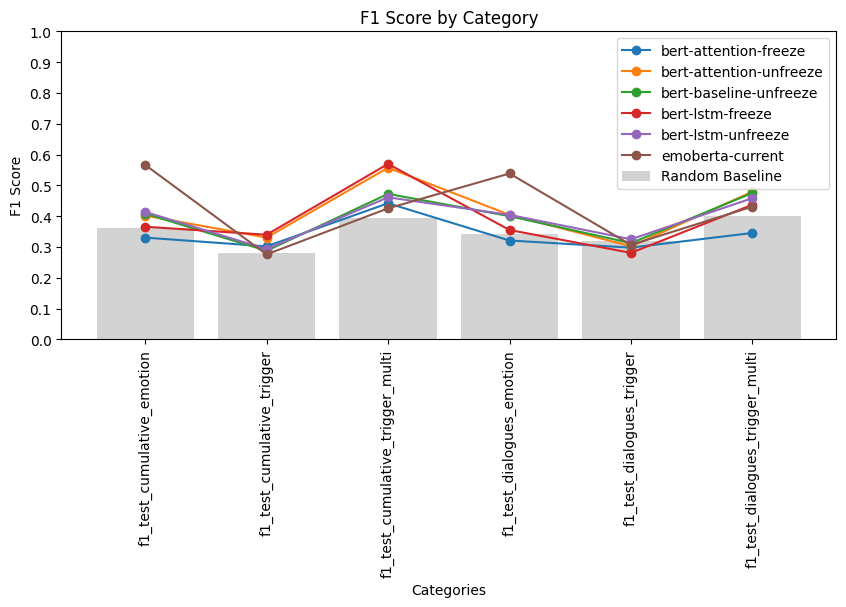

In [269]:
baseline_freeze = test_results_aggregated.loc["bert-baseline-freeze"]


# Sample data (replace this with your actual data)
plt.figure(figsize=(10, 4))
categories = test_results.columns.tolist()
# Bar chart
plt.bar(categories, test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc['bert-baseline-freeze'].tolist(), color='lightgray', label='Random Baseline')

# Line plot
for model_name in test_results_aggregated.index.tolist():
    if model_name == "bert-baseline-freeze":
        continue
    # Get mean for the current model
    
    model_results_mean = test_results_aggregated.iloc[:, test_results_aggregated.columns.get_level_values(1)=='mean'].loc[model_name].tolist()
    plt.plot(categories, model_results_mean, marker='o', linestyle='-', label=model_name)

# plt.plot(categories, f1_score_best_list + [f1_score_best_average], marker='o', linestyle='-', color='green', label='F1 Score (Line)')


# Adding labels and title
plt.xlabel('Categories')
plt.ylabel('F1 Score')
plt.title('F1 Score by Category')
plt.ylim(0, 1)
plt.xticks(rotation=90)
plt.legend()
plt.yticks(np.arange(0, 1.1, 0.1))

# Adding legend
plt.legend()

# Show the plot
plt.show()